<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/02_short_term_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio Strategy

### **Overview**
This notebook implements a systematic approach to building a short-term equity portfolio representing **15% of the complete portfolio**. The strategy combines:

- **Sentiment Analysis**: News-based sentiment scoring using Financial Modeling Prep API
- **Technical Analysis**: SMA/EMA cross signals with parameter optimization
- **Risk Management**: Statistical validation to prevent overfitting
- **Portfolio Construction**: Weighted allocation based on risk-adjusted returns

### **Key Features**
- ✅ News sentiment analysis from 30 days of market data
- ✅ Technical indicator optimization with walk-forward validation
- ✅ Overfitting detection using statistical tests
- ✅ Robust parameter selection across multiple market conditions
- ✅ Export to Excel for portfolio management integration

## **1. Environment Setup**

### Import Required Libraries

In [1]:
# System libraries
import glob
import os
import sys
import logging
import warnings
from io import StringIO
from typing import Dict, List
from dotenv import load_dotenv

# Data manipulation
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting
import bt

# Configuration
warnings.filterwarnings('ignore')
os.environ['YFINANCE_PROGRESS'] = 'False'
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

# Load environment variables
load_dotenv()

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## **2. Strategy Parameters**

### 2.1 Date Range Configuration
Define the backtesting period for strategy development and validation.

In [2]:
# Define the date range (10 years of historical data)
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Latest business day
start_date = end_date - timedelta(days=10*365)            # 10 years back

# Convert to timestamps for API calls
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Display configuration
days_difference = (end_date - start_date).days
print(f"📅 Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"📊 Time Span: {days_difference} days ({days_difference/365:.2f} years)")

📅 Analysis Period: 2015-06-14 to 2025-06-11
📊 Time Span: 3650 days (10.00 years)


### 2.2 Risk-Free Rate (Benchmark)
Using 13-week Treasury Bill rate as the risk-free benchmark for Sharpe ratio calculations.

In [3]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100

print(f"💰 Risk-Free Rate: {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%) - 13 Week Treasury Bill")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
💰 Risk-Free Rate: 0.0424 (4.24%) - 13 Week Treasury Bill


### 2.3 Portfolio File Management
Automatically selects the most recent portfolio file for integration.

In [4]:
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"📁 Using Portfolio File: {output_file}")
else:
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"📁 Creating New Portfolio File: {output_file}")

📁 Using Portfolio File: portfolios/portfolio-2025-06-10.xlsx


## **3. Market Sentiment Analysis**

### 3.1 News Data Collection
Fetches recent market news using Financial Modeling Prep API for sentiment analysis.

**API Details:**
- Source: [FMP Stock News API](https://site.financialmodelingprep.com/developer/docs/stable/stock-news)
- Period: Last 30 days
- Volume: Up to 15,000 articles (15 pages × 1,000 records)- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [5]:
from py.fetch_fmp_api import create_session, fetch_data

# API configuration
FMP_API_KEY = os.getenv('FMP_API_KEY')

# Fetch news data
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # 30-day lookback period
    max_pages=15,           # Maximum API pages to fetch
    records_per_page=1000,  # Records per API call
    request_timeout=10      # Connection timeout
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 999 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 1000 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14999


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""GTLL""","""2025-06-12 15:16:37""","""Global X Variable Rate Preferr…","""https://images.financialmodeli…","""seekingalpha.com""","""The fund invests primarily in …","""https://seekingalpha.com/artic…"
"""LGCFF""","""2025-06-12 15:16:00""","""Lavras Gold Announces Results …","""https://images.financialmodeli…","""newsfilecorp.com""","""Toronto, Ontario--(Newsfile Co…","""https://www.newsfilecorp.com/r…"
"""CODI""","""2025-06-12 15:15:00""","""Class Action Lawsuit Alert: Le…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""JPC""","""2025-06-12 15:11:34""","""JPC's Leverage Strategy Could …","""https://images.financialmodeli…","""seekingalpha.com""","""JPC offers a high yield of aro…","""https://seekingalpha.com/artic…"
"""ASTS""","""2025-06-12 15:11:17""","""These 24 Stocks Are Ripe for a…","""https://images.financialmodeli…","""schaeffersresearch.com""","""With the way negative stock ma…","""https://www.schaeffersresearch…"


### 3.2 Sentiment Analysis & Stock Screening

**Process Overview:**
1. **Text Analysis**: Uses TextBlob to analyze news headline sentiment
2. **Company Scoring**: Calculates company-specific news sentiment scores
3. **Sector Analysis**: Computes sector-level sentiment averages
4. **Fundamental Integration**: Merges with market cap, P/E ratios, and sector data

**Screening Criteria:**
- Minimum 3 articles in the last week (ensures sufficient data)
- Company news score ≥ 0.45 (filters for positive sentiment)

In [6]:
from py.sentiment_analysis import process_sentiment_analysis
import polars as pl

# Custom parameters
results = process_sentiment_analysis(
    news_df=news_df,
    fundamentals_path='data/fundamentals_stock.csv',
    min_articles=5,           # Require more articles
    min_news_score=0.5,       # Higher news score threshold  
    display_results=False     # Don't print results
)

# Extract all results
comprehensive_screened = results['comprehensive_screened']
sector_summary = results['sector_summary']

display(comprehensive_screened.head())
display(sector_summary)

📊 Loading fundamental stock data...
📈 Processing 504 stocks across 4209 unique tickers
🔍 Analyzing news sentiment by stock symbol...


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""AZEK""",11,0.7749,0.0,1.0,0.5499,11,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""HBFG""",5,0.7369,0.0,1.0,0.4737,5,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BRT""",6,0.728,0.0,0.8333,0.456,6,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""NICE""",12,0.7233,0.0,1.0,0.4465,12,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""ARTNA""",6,0.7152,0.0,0.8333,0.4305,6,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Real Estate""",23,0.58893,0.588383,8.434783,4.0380e10,59.008261
"""Consumer Cyclical""",42,0.578512,0.612669,15.404762,1.3643e11,32.742857
"""Utilities""",28,0.572193,0.499129,17.857143,4.1876e10,21.096429
"""Consumer Defensive""",31,0.570526,0.529226,16.967742,1.0391e11,21.669677
"""Healthcare""",54,0.568433,0.480474,12.12963,9.2179e10,27.541481
…,…,…,…,…,…,…
"""Industrials""",58,0.566976,0.5153,10.431034,6.5003e10,31.781379
"""Communication Services""",20,0.562095,0.48574,23.05,3.9500e11,20.262
"""Financial Services""",54,0.557509,0.457233,14.981481,1.0907e11,21.227778


### 3.3 Stock Universe Selection

**Selection Criteria:**
- Top 100 stocks ranked by `averageSentimentScore`
- Must have known sector classification
- Excludes stocks already in long-term portfolio (avoid overlap)
- Focus on stocks with strong positive sentiment momentum

In [7]:
# Load exclusions and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term_portfolio')['Ticker'].to_list()
selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()

print(f"🎯 Selected {len(screened_tickers)} stocks (excluded {len(long_term_tickers)} long-term holdings)")
display(selected_stocks.head())

🎯 Selected 100 stocks (excluded 5 long-term holdings)


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""DTE""",11,0.7112,0.0,1.0,0.4225,11,0.4991,0.5722,"""Utilities""",2.8013e10,18.1,134.99
"""USB""",5,0.6808,0.0,1.0,0.3617,5,0.4572,0.5575,"""Financial Services""",6.9402e10,10.94,44.54
"""ATO""",6,0.6782,0.0,0.6667,0.3563,6,0.4991,0.5722,"""Utilities""",2.4327e10,21.24,153.16
"""MCK""",5,0.6558,0.0,0.4,0.3115,5,0.4805,0.5684,"""Healthcare""",8.8848e10,27.78,710.78
"""ULTA""",5,0.6517,0.0,0.6,0.3033,5,0.6127,0.5785,"""Consumer Cyclical""",2.0583e10,18.14,457.96


## **4. Technical Analysis Setup**

### 4.1 Historical Price Data Loading
Loads and cleans historical price data for the selected stock universe.

In [8]:
# Load and clean price data
quotes = load_and_filter_data('data/daily_stock_quotes.csv', screened_tickers, start_date, end_date)
quotes = quotes.dropna(axis=1, how='any').dropna(axis=0, how='any')
available_tickers = quotes.columns.tolist()

print(f"📊 Loaded {len(available_tickers)} stocks with complete data ({quotes.shape[0]} days)")
display(quotes.head())

Found 99 of 100 tickers in data/daily_stock_quotes.csv
Missing tickers: ['GEV']
📊 Loaded 92 stocks with complete data (2512 days)


,ABT,ACN,AES,ALB,ALL,AMGN,AMP,ATO,AVGO,AWK,...,TT,ULTA,USB,VRTX,VZ,WBD,WELL,WMT,WSM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-15,39.75,81.32,9.33,50.59,53.73,116.60,102.97,40.69,10.89,40.99,...,45.31,154.570000,31.33,123.495,28.14,32.73,45.35,19.82,31.53,45.70
2015-06-16,40.09,82.09,9.43,50.64,54.26,116.70,103.43,41.09,10.81,40.68,...,45.32,155.500000,31.47,123.340,28.39,32.89,45.67,19.93,31.69,46.11
2015-06-17,40.16,82.29,9.49,51.05,54.14,116.26,103.34,41.23,10.74,40.86,...,45.27,155.619995,31.50,124.045,28.30,33.34,45.82,20.04,31.95,46.53
2015-06-18,41.30,82.61,9.62,52.09,55.09,119.60,104.25,41.84,10.92,41.59,...,45.56,156.479996,31.60,127.630,28.60,33.90,46.26,20.11,32.18,46.84
2015-06-19,41.25,82.37,9.62,51.19,53.55,120.05,102.93,41.69,10.91,41.47,...,45.27,154.729996,31.50,128.040,28.41,33.91,46.17,20.04,31.76,46.60


### 4.2 Train-Test Split

**Methodology:**
- **Training Set**: 80% (historical data for parameter optimization)
- **Testing Set**: 20% (recent data for out-of-sample validation)
- **Time-based Split**: Ensures realistic forward-testing conditions

In [9]:
# Split data chronologically
train_size = int(0.8 * len(quotes))
training_set = quotes.iloc[:train_size]
test_set = quotes.iloc[train_size:]

print(f"📊 Split: {len(training_set)} training ({len(training_set)/len(quotes):.1%}), {len(test_set)} testing rows ({len(test_set)/len(quotes):.1%})")
print(f"Training Period: {training_set.index[0]} - {training_set.index[-1]}")
print(f"Testing Period: {test_set.index[0]} - {test_set.index[-1]}")

📊 Split: 2009 training (80.0%), 503 testing rows (20.0%)
Training Period: 2015-06-15 00:00:00 - 2023-06-06 00:00:00
Testing Period: 2023-06-07 00:00:00 - 2025-06-09 00:00:00


## **5. Technical Strategy Optimization**

### 5.1 Parameter Configuration

**Trading Signals:**
- **SMA Cross**: Simple Moving Average crossover signals
- **EMA Cross**: Exponential Moving Average crossover signals

**Optimization Profiles:**
- **Aggressive**: Faster signals, higher turnover
- **Conservative**: Slower signals, more stable
- **Ultra-Conservative**: Very slow signals, lowest turnover

**Key Constraints:**
- Maximum 2 stocks per portfolio (concentration limit)
- Multiple parameter iterations for robustness testing

In [10]:
max_stocks = 2

# Define parameter optimization profiles
custom_parameter_iterations = [
    {
        'name': 'Aggressive', 
        'ranges': {
            'SMA_Cross_Signal': {
                'short_periods': [10, 15, 20], 
                'long_periods': [50, 75, 100]
            }, 
            'EMA_Cross_Signal': {
                'short_periods': [8, 12, 16], 
                'long_periods': [25, 35, 45]
            }
        }
    },
    {
        'name': 'Conservative', 
        'ranges': {
            'SMA_Cross_Signal': {
                'short_periods': [20, 30, 40, 50], 
                'long_periods': [100, 120, 140, 160]
            }, 
            'EMA_Cross_Signal': {
                'short_periods': [12, 20, 26], 
                'long_periods': [50, 60, 70]
            }
        }
    },
    {
        'name': 'Ultra-Conservative', 
        'ranges': {
            'SMA_Cross_Signal': {
                'short_periods': [20, 50], 
                'long_periods': [100, 150]
            }, 
            'EMA_Cross_Signal': {
                'short_periods': [12, 26], 
                'long_periods': [50, 70]
            }
        }
    }
]

print(f"🎯 Maximum portfolio size: {max_stocks} stocks")

🎯 Maximum portfolio size: 2 stocks


### 5.2 Robust Strategy Selection with Validation

**Process:**
1. **Multi-Parameter Testing**: Tests various SMA/EMA combinations
2. **Stock Rotation**: Tries different stock combinations  
3. **Overfitting Detection**: Statistical tests for strategy robustness
4. **Walk-Forward Validation**: Validates across multiple time periods
5. **Fallback Logic**: Single-stock strategies if multi-stock fails

**Success Criteria:**
- Strategy not statistically overfitted (p-value > 0.05)
- Stability ratio ≥ 50% across validation periods
- Positive risk-adjusted returns (Sharpe ratio > 0)

🔄 Running robust strategy optimization...
🎯 ENHANCED STRATEGY SELECTION WITH STOCK ROTATION & OVERFITTING PROTECTION
📊 Valid tickers after filtering: 92/92
Testing 15 random combinations out of 4186 possible
📊 Available tickers: ['ABT', 'ACN', 'AES', 'ALB', 'ALL', 'AMGN', 'AMP', 'ATO', 'AVGO', 'AWK', 'BAC', 'BK', 'BKNG', 'BMY', 'CB', 'CCL', 'CDNS', 'CL', 'CMCSA', 'CME', 'CMG', 'CMS', 'CNC', 'COO', 'COST', 'CSCO', 'CTAS', 'CTSH', 'CVS', 'DAL', 'DIS', 'DTE', 'EMR', 'ETN', 'FCX', 'FICO', 'FOX', 'FSLR', 'GE', 'GEN', 'GOOGL', 'GRMN', 'HAL', 'HD', 'HII', 'HWM', 'IFF', 'INTU', 'ISRG', 'JNJ', 'LDOS', 'MAR', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MMM', 'MO', 'MOS', 'MS', 'MSCI', 'MSFT', 'NEE', 'NEM', 'NFLX', 'NOW', 'ODFL', 'PANW', 'PEG', 'PEP', 'PFE', 'RCL', 'RF', 'ROK', 'RTX', 'SLB', 'STLD', 'STX', 'SYF', 'TEL', 'TGT', 'TJX', 'TT', 'ULTA', 'USB', 'VRTX', 'VZ', 'WBD', 'WELL', 'WMT', 'WSM', 'ZTS']
Creating combinations of 2 stocks...
Testing 20 random combinations out of 4186 possible

🔄 STOCK COMBINATIO

    ⚠️ No optimization results in iteration 1
  🔄 ITERATION 2: Conservative Parameters
    ⚠️ No optimization results in iteration 2
  📊 No stable strategy found for ('BAC', 'MOS')

🔄 STOCK COMBINATION 2/20: ['AES', 'CTAS']
------------------------------------------------------------
  🔄 ITERATION 1: Aggressive Parameters
🔍 Running Overfitting Analysis...
📊 SUMMARY STATISTICS
Strategies tested: 1
In-sample mean Sharpe: 0.536
Out-sample mean Sharpe: 0.289
In-sample mean Sortino: 0.742
Out-sample mean Sortino: 0.348

📈 STATISTICAL TEST RESULTS
Sharpe t-statistic: 1.297
Sharpe p-value: 0.209
Sortino t-statistic: 1.513
Sortino p-value: 0.186

🎯 OVERFITTING STATUS: NOT DETECTED
   ✅ Sharpe ratio degradation not significant (p=0.209)
   ✅ Sortino ratio degradation not significant (p=0.186)

💡 RECOMMENDATIONS:
  ✅ NO SIGNIFICANT OVERFITTING: The strategy maintains reasonable performance from in-sample to out-of-sample testing.
  💡 Continue monitoring:
  • Track performance over time
  • Consi

,Ticker,Strategy,Best_Sharpe,Best_Sortino,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,LDOS,EMA_Cross_Signal,0.436987,0.590499,0.086787,-0.443184,0.280768,8,25


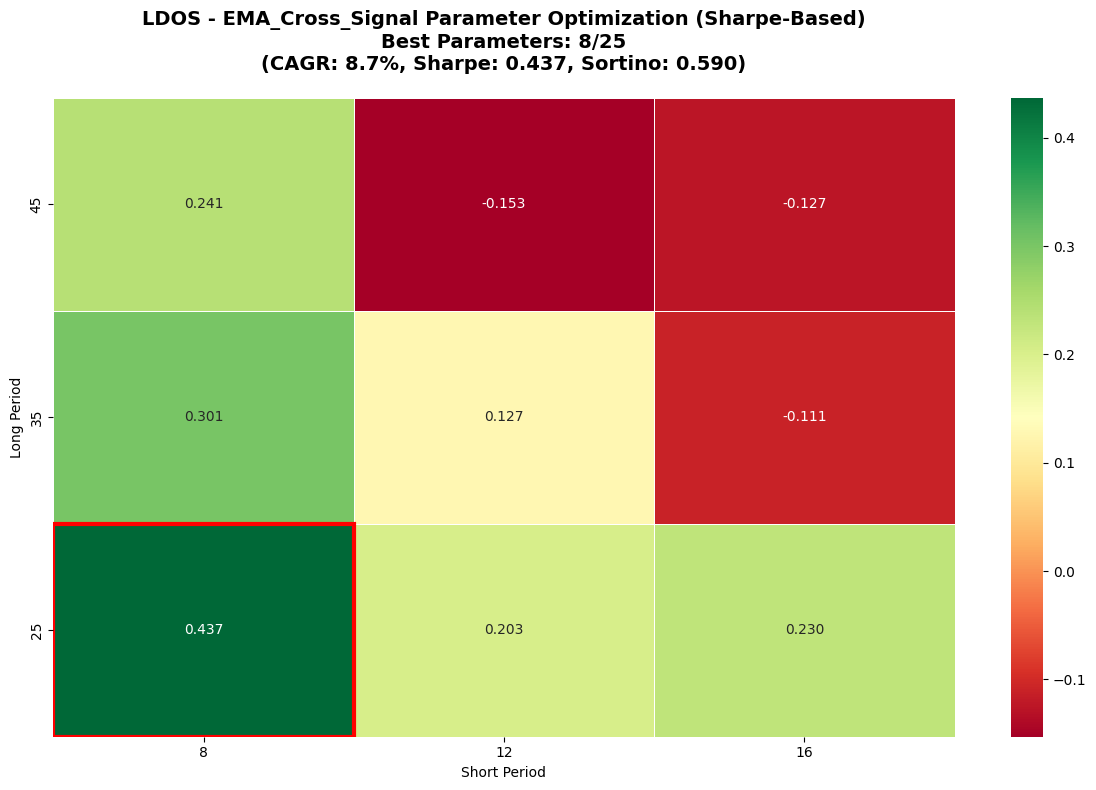


🎯 Final: ['LDOS'] | ✅ VALIDATED


In [11]:
from py.technical_analysis import run_complete_strategy_optimization

strategy_result = run_complete_strategy_optimization(
    quotes, available_tickers, max_stocks=max_stocks, 
    custom_parameter_iterations=custom_parameter_iterations,
    max_iterations=2  
)

# Extract results
optimization_results = strategy_result['optimization_results']
optimization_summary = strategy_result['optimization_summary'] 
selected_tickers = strategy_result['selected_tickers']
is_overfitted = strategy_result['is_overfitted']
sharpe_p_value = strategy_result['sharpe_p_value']
stability_ratio = strategy_result['stability_ratio']

# Final summary
validation_emoji = '✅ VALIDATED' if not is_overfitted and stability_ratio >= 0.5 else '⚠️ BEST EFFORT'
print(f"\n🎯 Final: {selected_tickers} | {validation_emoji}")

### 5.3 Out-of-Sample Strategy Testing

**Testing Methodology:**
- Uses the reserved 20% test set (unseen during optimization)
- Applies optimized parameters to fresh data
- Measures real-world strategy performance
- Validates strategy robustness outside training period

**Performance Metrics:**
- Total Return, Volatility, Sharpe Ratio
- Maximum Drawdown, Win Rate
- Risk-adjusted performance vs benchmark

🧪 Testing strategy on out-of-sample data...


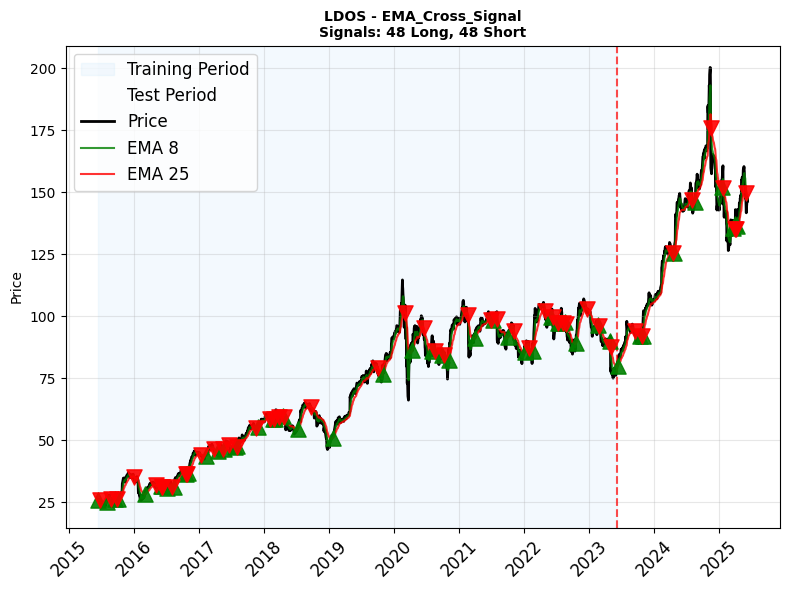

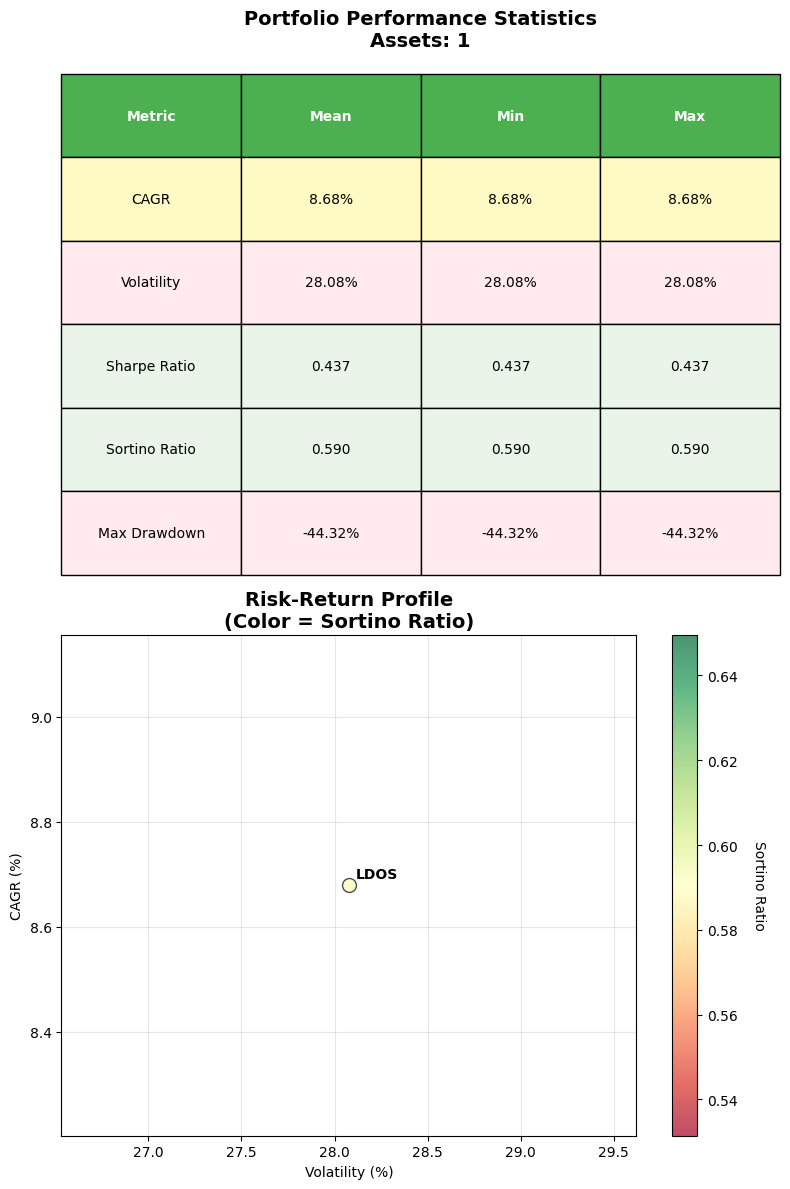

100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


📊 Selected: ['LDOS']
Stat                 Short-Term Strategy
-------------------  ---------------------
Start                2023-06-06
End                  2025-06-09
Risk-free rate       4.24%

Total Return         81.47%
Daily Sharpe         1.13
Daily Sortino        1.79
CAGR                 34.52%
Max Drawdown         -36.86%
Calmar Ratio         0.94

MTD                  -1.47%
3m                   5.42%
6m                   -8.20%
YTD                  1.89%
1Y                   2.12%
3Y (ann.)            34.52%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  34.52%

Daily Sharpe         1.13
Daily Sortino        1.79
Daily Mean (ann.)    33.17%
Daily Vol (ann.)     25.61%
Daily Skew           -0.60
Daily Kurt           15.89
Best Day             9.50%
Worst Day            -13.60%

Monthly Sharpe       1.05
Monthly Sortino      1.97
Monthly Mean (ann.)  29.20%
Monthly Vol (ann.)   23.78%
Monthly Skew         -0.39
Monthly Kurt         0.13
Best Month         

<Axes: title={'center': 'Portfolio Out-of-Sample Performance'}>

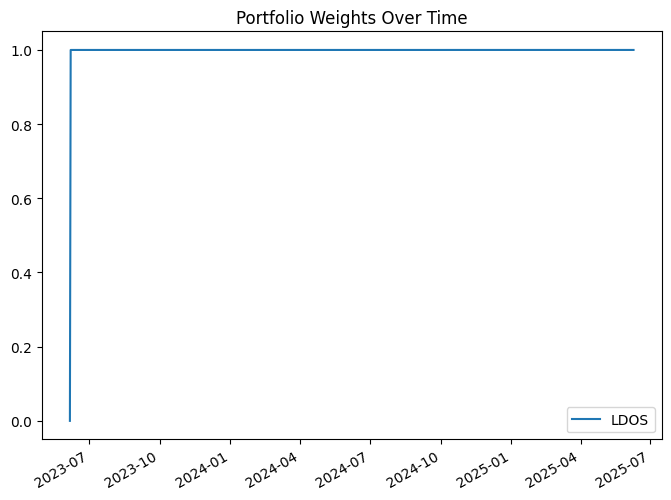

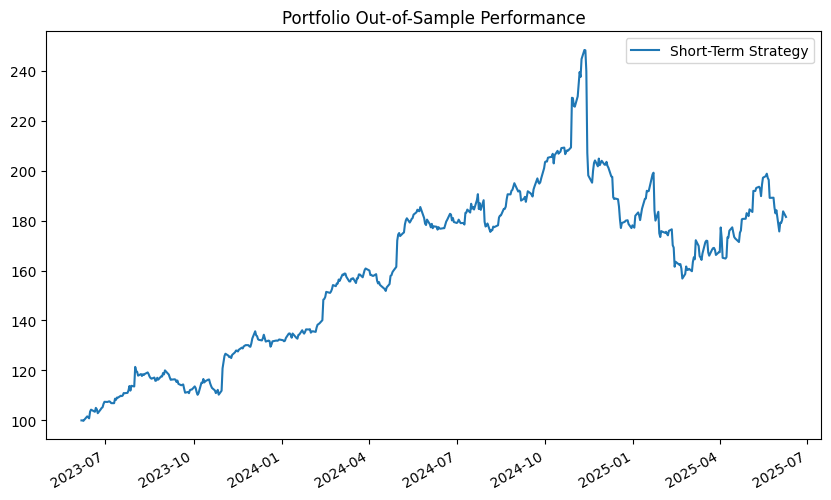

In [16]:
from py.technical_analysis import plot_complete_strategy_analysis, plot_portfolio_performance

print("🧪 Testing strategy on out-of-sample data...")

# Generate analysis plots
plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=1)
plot_portfolio_performance(optimization_summary, cols=1, rows=2)

# Extract portfolio configuration
portfolio_weights = optimization_results['portfolio_weights']
selected_tickers = optimization_results['selected_tickers']
portfolio_test_data = quotes[selected_tickers].dropna().loc[test_set.index]

# Process portfolio weights
if isinstance(portfolio_weights, pd.DataFrame) and len(portfolio_weights) == len(selected_tickers):
    weights_dict = {ticker: portfolio_weights.iloc[i, 0] for i, ticker in enumerate(selected_tickers)}
elif isinstance(portfolio_weights, dict):
    weights_dict = {ticker: portfolio_weights.get(ticker, 1.0/len(selected_tickers)) for ticker in selected_tickers}
else:
    weights_dict = {ticker: 1.0/len(selected_tickers) for ticker in selected_tickers}

# Normalize weights
total_weight = sum(weights_dict.values())
if total_weight > 0:
    weights_dict = {k: v/total_weight for k, v in weights_dict.items()}

# Run backtest
portfolio_strategy = bt.Strategy('Short-Term Strategy', [
    bt.algos.RunWeekly(), bt.algos.SelectAll(), 
    bt.algos.WeighSpecified(**weights_dict), bt.algos.Rebalance()
])

portfolio_result = bt.run(bt.Backtest(portfolio_strategy, portfolio_test_data))
portfolio_result.set_riskfree_rate(risk_free_rate)

print(f"📊 Selected: {selected_tickers}")
portfolio_result.display()
portfolio_result.plot_security_weights(figsize=(8, 6), title='Portfolio Weights Over Time')
portfolio_result.plot(figsize=(10, 6), title='Portfolio Out-of-Sample Performance')

### 5.4 Statistical Overfitting Analysis

**Purpose:**
Determines if the optimized strategy is likely to perform well on future unseen data or if it's overfitted to historical patterns.

**Tests Performed:**
- **Sharpe Ratio Stability**: Compares in-sample vs out-of-sample Sharpe ratios
- **Statistical Significance**: Tests if performance differences are statistically meaningful
- **Return Distribution Analysis**: Examines consistency of return patterns

**Interpretation:**
- **p-value < 0.05**: Likely overfitted, proceed with caution
- **p-value ≥ 0.05**: Strategy appears robust for future deployment

In [17]:
from py.technical_analysis import run_overfitting_analysis

# Run overfitting analysis
overfitting_analysis = run_overfitting_analysis(optimization_results, test_set)
is_overfitted = overfitting_analysis['statistical_tests'].get('is_overfitted', False)
sharpe_p_value = overfitting_analysis['statistical_tests'].get('sharpe_p_value', 1.0)

status = "⚠️ OVERFITTED" if is_overfitted else "✅ VALIDATED"
print(f"📊 Overfitting: {status} (p={sharpe_p_value:.4f})")

🔍 Running Overfitting Analysis...
📊 SUMMARY STATISTICS
Strategies tested: 1
In-sample mean Sharpe: 0.100
Out-sample mean Sharpe: 0.378
In-sample mean Sortino: 0.141
Out-sample mean Sortino: 0.427

📈 STATISTICAL TEST RESULTS
Sharpe t-statistic: -0.476
Sharpe p-value: 0.641
Sortino t-statistic: -0.368
Sortino p-value: 0.612

🎯 OVERFITTING STATUS: NOT DETECTED
   ✅ Sharpe ratio degradation not significant (p=0.641)
   ✅ Sortino ratio degradation not significant (p=0.612)

💡 RECOMMENDATIONS:
  ✅ NO SIGNIFICANT OVERFITTING: The strategy maintains reasonable performance from in-sample to out-of-sample testing.
  💡 Continue monitoring:
  • Track performance over time
  • Consider additional validation periods
  • Monitor parameter stability

📋 DETAILED TICKER ANALYSIS:

LDOS:
  In-sample Sharpe: -0.237
  Out-sample Sharpe: 0.378
  Degradation: -259.2%
  Strategy: EMA_Cross_Signal
  Periods: 8/25
📊 Overfitting: ✅ VALIDATED (p=0.6415)


### 5.5 Walk-Forward Validation

**Methodology:**
- Simulates real-world strategy deployment over multiple time periods
- Re-optimizes parameters periodically (mimicking live trading)
- Tests strategy stability across different market conditions
- Provides additional confirmation of strategy robustness

**Validation Periods:**
Multiple non-overlapping time windows to test parameter stability and performance consistency.

In [ ]:
from py.technical_analysis import walk_forward_validation_check

# Define parameter ranges
parameter_ranges = robust_strategy_results.get('parameter_config', {
    'SMA_Cross_Signal': {'short_periods': [20], 'long_periods': [100]},
    'EMA_Cross_Signal': {'short_periods': [12], 'long_periods': [50]}
}) if 'robust_strategy_results' in locals() and robust_strategy_results else {
    'SMA_Cross_Signal': {'short_periods': [20], 'long_periods': [100]},
    'EMA_Cross_Signal': {'short_periods': [12], 'long_periods': [50]}
}

# Run validation
validation_results = walk_forward_validation_check(
    quotes_data=quotes, parameter_ranges=parameter_ranges, 
    is_overfitted=is_overfitted, sharpe_p_value=sharpe_p_value,
    overfitting_analysis=overfitting_analysis, selected_tickers=selected_tickers,
    risk_free_rate=risk_free_rate, validation_periods=4
)

stability_ratio = validation_results['stability_ratio']
print(f"🚶 Walk-Forward: {validation_results['final_status']} | Stability: {stability_ratio:.1%}")


✅ Skipping walk-forward validation - no overfitting detected

📋 FINAL STRATEGY VALIDATION SUMMARY
🎯 STRATEGY STATUS: READY FOR DEPLOYMENT
✅ Passed overfitting tests (p-value: 0.2091)

💡 DEPLOYMENT RECOMMENDATIONS:
  ✅ Strategy appears robust
  📊 Monitor performance closely
  🎯 Consider paper trading first
  📈 Set up regular re-optimization
  ⚖️ Implement risk management

📊 STRATEGY METRICS:
Selected tickers: ['CTAS']
Portfolio size: 1 stocks
Training Sharpe: 0.536
Testing Sharpe: 0.289
Risk-free rate: 4.240%
🚶 Walk-Forward: READY_FOR_DEPLOYMENT | Stability: 100.0%


## **6. Portfolio Construction & Integration**

### 6.1 Merge Strategy Results with Fundamental Data

**Data Integration:**
- **Technical Analysis**: Optimized parameters and performance metrics
- **Sentiment Analysis**: News-based sentiment scores and sector analysis  
- **Fundamental Analysis**: Market cap, P/E ratios, sector classifications
- **Risk Metrics**: Sharpe ratios, volatility, maximum drawdown

**Weight Calculation:**
Portfolio weights are determined by normalized Sharpe ratios to emphasize risk-adjusted performance.

In [ ]:
from py.utils import clean_column_names

# Load and prepare fundamentals data
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
if 'Ticker' not in fundamentals_df.columns:
    ticker_col = next((col for col in fundamentals_df.columns 
                      if col.lower() in ['symbol', 'ticker', 'stock', 'code']), None)
    if ticker_col:
        fundamentals_df = fundamentals_df.with_columns(
            pl.col(ticker_col).str.to_uppercase().alias("Ticker")
        ).drop(ticker_col)

# Prepare optimization and sentiment data
optimization_summary_with_tickers = optimization_summary.copy()
optimization_summary_with_tickers['Ticker'] = [ticker.upper() for ticker in selected_tickers]

sentiment_merge = comprehensive_screened.select([
    'symbol', 'articlesInLastWeek', 'companyNewsScore', 
    'bearishPercent', 'bullishPercent', 'averageSentimentScore',
    'sectorAverageBullishPercent', 'sectorAverageNewsScore'
]).with_columns(pl.col("symbol").str.to_uppercase().alias("Ticker")).drop('symbol')

# Create and weight portfolio
short_term_portfolio_df = (fundamentals_df
    .join(pl.DataFrame(optimization_summary_with_tickers), on='Ticker', how='inner')
    .join(sentiment_merge, on='Ticker', how='inner')
    .to_pandas().set_index('Ticker').sort_index().pipe(clean_column_names))

# Calculate weights based on Sharpe ratios
if 'sharpe_ratio' in short_term_portfolio_df.columns and short_term_portfolio_df['sharpe_ratio'].sum() > 0:
    short_term_portfolio_df['Weight'] = short_term_portfolio_df['sharpe_ratio'] / short_term_portfolio_df['sharpe_ratio'].sum()
else:
    short_term_portfolio_df['Weight'] = 1.0 / len(short_term_portfolio_df)

print(f"✅ Portfolio: {len(short_term_portfolio_df)} stocks")
display(short_term_portfolio_df)

✅ Portfolio: 1 stocks


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score,Weight
Ticker,,,,,,,,,,,,,,,,,,,,,
CTAS,2025-06-11,Cintas Corporation,Industrials,Specialty Business Services,United States,https://www.cintas.com,8.962861e+10,9.217796e+10,343101820.0,403787008.0,...,15,50,5,0.6461,0.0,0.6,0.2921,0.5153,0.567,1.0


### 6.2 Price Data Preparation for Export

**Daily Prices:**
- Complete daily price history for selected stocks
- Includes risk-free rate for performance benchmarking
- All column names standardized to uppercase

**Monthly Prices:**
- Resampled to month-start frequency
- Useful for monthly portfolio reporting and analysis
- Maintains same structure as daily data

In [ ]:
# Merge portfolio quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create monthly resampled data
monthly_prices_df_merged = daily_prices_df_merged.copy()
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to month-start and take last value of each month
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display monthly data sample
print(f"Date Range: {daily_prices_df_merged.index[0]} - {daily_prices_df_merged.index[-1]}")
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True).head())

Date Range: 2015-06-15 00:00:00 - 2025-06-09 00:00:00


,CTAS,^IRX
Date,,
2025-06-01,224.60,4.240
2025-05-01,226.50,4.230
2025-04-01,211.29,4.190
2025-03-01,205.16,4.190
2025-02-01,207.12,4.193


## **7. Portfolio Export & Summary**

### Export to Excel
The final portfolio is exported to Excel with multiple sheets for comprehensive analysis:

- **short_term_portfolio**: Complete portfolio with all metrics and weights
- **daily_quotes**: Daily price history for backtesting and analysis  
- **monthly_quotes**: Monthly price data for reporting

### Final Portfolio Summary

In [ ]:
from py.utils import export_to_excel

# Export portfolio to Excel
export_to_excel(output_file, {
    'short_term_portfolio': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

# Portfolio summary
validation_status = '✅ PASSED' if not is_overfitted else '⚠️ REVIEW NEEDED'
print(f"✅ EXPORT: {output_file}")
print(f"\n🎯 PORTFOLIO SUMMARY")
print(f"📈 Tickers: {selected_tickers}")
print(f"💼 Size: {len(short_term_portfolio_df)} stocks | Allocation: {short_term_portfolio_df['Weight'].sum():.1%}")
print(f"🔍 Validation: {validation_status} | P-Value: {sharpe_p_value:.4f} | Stability: {stability_ratio:.1%}")
print(f"💰 Weights: {', '.join(f'{t}: {w:.1%}' for t, w in zip(selected_tickers, short_term_portfolio_df['Weight'].values))}")
print(f"🚀 Ready for deployment!")

Updated sheet 'short_term_portfolio'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-10.xlsx
✅ EXPORT: portfolios/portfolio-2025-06-10.xlsx

🎯 PORTFOLIO SUMMARY
📈 Tickers: ['CTAS']
💼 Size: 1 stocks | Allocation: 100.0%
🔍 Validation: ✅ PASSED | P-Value: 0.2091 | Stability: 100.0%
💰 Weights: CTAS: 100.0%
🚀 Ready for deployment!
